# Setup

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
# from tensorflow.keras import layers
import numpy as np
from numpy.random import default_rng
import scipy.linalg as la
from scipy.special import gammaln
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import netCDF4 as nc
import re
import pandas as pd
import sklearn as skl
import seaborn as sns
from tqdm.auto import tqdm
import tuning_fun as tu
import emulator_fun as ef
import time


2025-05-27 12:06:09.502936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 12:06:09.513699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748361969.525515 1926069 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748361969.529110 1926069 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 12:06:09.542878: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# allocating GPU memory

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# model

## read files

In [150]:
case_name = 'rainshaft_Vx_r1_N10000_dt300'
base_path = 'summary_ncs/'
# base_path = '/Users/arthurhu/github/BOSS_PPE/summary_ncs/'
# base_path = '/pscratch/sd/a/arthurhu/BOSS_PPE/summary_ncs/'
filename = case_name + '.nc'

param_all_idx = np.arange(39)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, filename, param_interest_idx)

nppe, npar = param_train['vals'].shape

n_input = param_train['vals'].shape[1]


In [151]:
dataset = nc.Dataset(base_path + filename, mode='r')
n_init = getattr(dataset, 'n_init')
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [152]:
n_tgt_ics = tgt_raw_vals[0].shape[0]
npar = n_input - n_init
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [153]:
ppe_var_presence = ppe_asinh = ppe_all = np.empty((nppe,0), dtype=np.float32)
ncases = tgt_raw_vals[0].shape[0]
tgt_var_presence = tgt_asinh = tgt_all = np.empty((ncases,0), dtype=np.float32)

for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)
    ppe_var_presence = np.concatenate((ppe_var_presence, ppe_raw_val_reshaped > eff0s[idx]/100), axis=1)
    ppe_asinh_reshaped = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
    ppe_asinh = np.concatenate((ppe_asinh, ppe_asinh_reshaped), axis=1)
    tgt_var_presence = np.concatenate((tgt_var_presence, tgt_raw_val_reshaped > eff0s[idx]/100), axis=1)
    tgt_asinh_reshaped = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
    tgt_asinh = np.concatenate((tgt_asinh, tgt_asinh_reshaped), axis=1)


In [154]:
init_vars = getattr(dataset, 'init_var')
if isinstance(init_vars, str):
    init_vars = [init_vars]

initvar_matrix = []

for i_init, init_var in enumerate(init_vars):
    initvar_matrix.append(np.expand_dims(dataset.variables['case_' + init_var][:], axis=1))

tgt_sim_ics = np.concatenate(initvar_matrix, axis=1)

In [155]:
from sklearn import preprocessing
import sklearn.model_selection as mod_sec

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

standscale = preprocessing.StandardScaler().fit(ppe_asinh)
ppe_all = standscale.transform(ppe_asinh)
tgt_all = standscale.transform(tgt_asinh)

x_train, x_val, y_train_wpresence, y_val_wpresence = mod_sec.train_test_split(x_all, ppe_var_presence, test_size=0.2, random_state=1)
_, _, y_train, y_val = mod_sec.train_test_split(x_all, ppe_all, test_size=0.2, random_state=1)

y_train = np.nan_to_num(y_train, nan=-1001)
y_val = np.nan_to_num(y_val, nan=-1001)

In [156]:
ppe_raw_vals[5].size/50000

144.0

(array([2.900e+01, 9.000e+00, 1.000e+01, 3.600e+01, 2.200e+01, 5.100e+01,
        3.600e+01, 6.300e+01, 6.000e+01, 1.130e+02, 1.380e+02, 2.740e+02,
        3.610e+02, 4.510e+02, 4.190e+02, 4.170e+02, 5.310e+02, 5.710e+02,
        6.320e+02, 8.180e+02, 9.760e+02, 1.255e+03, 1.449e+03, 1.663e+03,
        1.882e+03, 2.923e+03, 2.650e+03, 2.232e+03, 9.550e+02, 6.360e+02,
        7.400e+02, 7.640e+02, 9.240e+02, 1.337e+03, 1.606e+03, 7.480e+02,
        2.940e+02, 5.400e+01, 4.000e+01, 5.700e+01, 3.500e+01, 2.300e+01,
        0.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

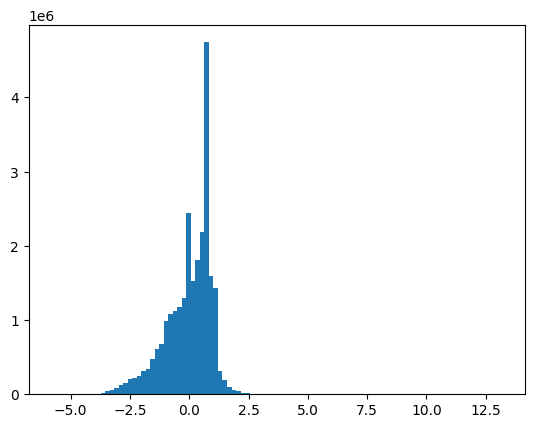

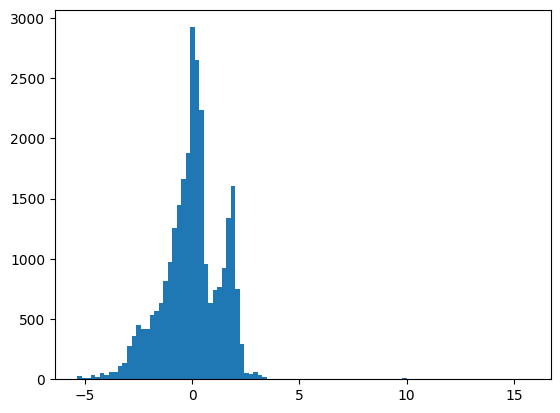

In [157]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 0
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
# plt.hist(y_all[:,5:65].flatten(), bins=100)
# plt.figure()
# plt.hist(tgt_all[:,5:65].flatten(), bins=100)

plt.hist(ppe_all[:,a+6:a+2580].flatten(), bins=100)
plt.figure()
plt.hist(tgt_all[:,a+6:a+2580].flatten(), bins=100)

In [158]:
# cc_model = tf.keras.models.load_model('condcoll_multioutput_try5_no_dropout.keras', compile=False)
cc_model = tf.keras.models.load_model('models/multioutput_try14_rainshaft_Vmx_r1.keras', compile=False)


In [159]:
# REVIEW: check every time if this is true ... not sure how to implement this programatically
param_table = pd.read_csv('/home/arthurhu/Cloud_BOSS/param_consolid_RICO.csv')
# param_table = pd.read_csv('/Users/arthurhu/Library/Mobile Documents/com~apple~CloudDocs/storage/postdoc/CloudBOSS/param_consolid_RICO.csv')
# param_table = pd.read_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_RICO.csv')
param_names = param_table.columns[param_interest_idx + 1].to_list()
param_names.append('sigma')
param_mean = param_table.values[0, param_interest_idx + 1].astype(np.float32)
param_std = param_table.values[1, param_interest_idx + 1].astype(np.float32)
# param_std[param_not_int_idx] = 0

## run

In [160]:
tfd = tfp.distributions
tfb = tfp.bijectors

nchains = 8
# tf.keras.backend.set_floatx('float32')
IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = minmaxscale.transform(IC_with_dummy)[:,:n_init].astype('float32')
valid_mask = tf.math.is_finite(tgt_all)
weights = np.ones([n_tgt_ics, nobs]).astype('float32')


In [161]:
params = tf.zeros(npar) + 0.5
params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
param_lp = tf.reduce_sum(tfd.Uniform(low=0.0,
                                     high=1.0).log_prob(params_2d))
input_norm = tf.concat([IC_norm, params_2d], axis=1) # n_tgt_ics x n_input
y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs
obs_lps = tfd.Normal(loc=tf.cast(tgt_all, tf.float32), scale=1.).log_prob(tf.cast(y_emu[1]*y_emu[0], tf.float32))

eps = 1e-7
y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
valid_mask_float = tf.cast(valid_mask, tf.float32)
wpresence_lps = tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float)
wpresence_lp = tf.reduce_sum(wpresence_lps)

print(tf.reduce_sum(obs_lps), wpresence_lp)

tf.Tensor(-59907.234, shape=(), dtype=float32) tf.Tensor(-70571.92, shape=(), dtype=float32)


In [162]:
param_lps = []
sigma_lps = []
obs_lps = []
# wpresence_lps = []
exp_rate = 1
sigmas = []
initial_state = tf.random.normal([nchains, npar+1], seed=0)

for i in tqdm(range(1000)):
    initial_state = tf.concat([
    tf.random.normal([npar]),
    tf.random.normal([1])], axis=-1)

    # initial_state = tf.zeros(npar, dtype='float32')
    params = initial_state[:-1]
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
    theta=tfb.Sigmoid().forward(params_2d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta))

    log_sigma = initial_state[-1]
    sigma = tf.exp(log_sigma)
    sigma_lp = tfd.Uniform(low=0.1, high=5).log_prob(sigma)
    # sigma_lp = tfd.Exponential(rate=exp_rate).log_prob(sigma) + log_sigma

    input_norm = tf.concat([IC_norm, theta], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs
    # y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
    # FIXME: retrain the model usign logits to avoid arbitrary eps threshold
    # eps = 1e-7
    # y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
    # valid_mask_float = tf.cast(valid_mask, tf.float32)
    # wpresence_lp = tf.reduce_sum(tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float))

    y_emu_obs_norm = y_emu[1] * y_emu[0]
    # y_emu_obs_norm_valid = tf.boolean_mask(y_emu_obs_norm, valid_mask)
    # y_emu_obs_norm_valid = tf.where(tf.math.is_nan(y_emu_obs_norm_valid), tf.constant(-20, dtype=y_emu_obs_norm_valid.dtype), y_emu_obs_norm_valid)
    tgt_all_valid = tf.boolean_mask(tgt_all, valid_mask)
    # weights_valid = tf.boolean_mask(weights, valid_mask)
    obs_lp = tf.reduce_sum(tfd.Normal(loc=tf.cast(tgt_all, tf.float32), scale=sigma).log_prob(tf.cast(y_emu_obs_norm, tf.float32)))
    param_lps.append(param_lp)
    obs_lps.append(obs_lp)
    # wpresence_lps.append(wpresence_lp)
    sigma_lps.append(sigma_lp)
    sigmas.append(sigma)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [163]:
s_obs = np.std(param_lps)/np.std(obs_lps)
# s_wpr = np.std(param_lps)/np.std(wpresence_lps)
s_sig = np.std(param_lps)/np.std(sigma_lps)
s_obs, s_sig

/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(1.7318915e-05, nan)

In [164]:
eps = 1e-7

def toy_lp(params_sigma):
    params = params_sigma[:-1]
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar

    theta=tfb.Sigmoid().forward(params_2d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta))
    # get sigma
    log_sigma = params_sigma[-1]
    sigma = tf.exp(log_sigma)
    # sigma_lp = tfd.Exponential(rate=exp_rate).log_prob(sigma) + log_sigma
    sigma_lp = tfd.Uniform(low=0.1, high=5).log_prob(sigma)

    # get normalized ICs
    input_norm = tf.concat([IC_norm, theta], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs

    # # emulated water presence
    # y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
    # # FIXME: retrain the model usign logits to avoid arbitrary eps threshold
    # y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
    # valid_mask_float = tf.cast(valid_mask, tf.float32)
    # wpresence_lps = tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float)
    # wpresence_lp = tf.reduce_sum(wpresence_lps)

    # emulated observed value
    y_emu_obs_norm = y_emu[1] * y_emu[0]
    # y_emu_obs_norm_valid = tf.boolean_mask(y_emu_obs_norm, valid_mask)
    # y_emu_obs_norm_valid = tf.where(tf.math.is_nan(y_emu_obs_norm_valid), tf.constant(-20, dtype=y_emu_obs_norm_valid.dtype), y_emu_obs_norm_valid)
    # tgt_all_valid = tf.boolean_mask(tgt_all, valid_mask)
    # weights_valid = tf.boolean_mask(weights, valid_mask)
    obs_lps = tfd.Normal(loc=tf.cast(tgt_all, tf.float32), scale=sigma).log_prob(tf.cast(y_emu_obs_norm, tf.float32)) #*weights_valid
    obs_lp = tf.reduce_sum(obs_lps)
    return param_lp + obs_lp * s_obs + sigma_lp

batched_toy_lp = lambda params_batch: tf.vectorized_map(
toy_lp, params_batch)

num_burnin_steps = 2500
num_samples = 5000
initial_state = tf.random.normal([nchains, npar+1], seed=0)
# initial_state = tf.concat([tf.random.normal([nchains, npar], seed=0),
#                            tf.zeros([nchains, 1])], axis=1)

stepsize = 0.01

hmc = tfp.mcmc.HamiltonianMonteCarlo(batched_toy_lp, step_size=stepsize, num_leapfrog_steps=3)
adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc,
    num_adaptation_steps=int(num_burnin_steps * 0.8))

start = time.time()
samples, kr = tfp.mcmc.sample_chain(num_results=num_samples,
    current_state=initial_state,   # or your initial_state
    kernel=adaptive_hmc,
    num_burnin_steps=num_burnin_steps,
    seed=0)

end = time.time()
print(end-start)

/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


10666.280497550964


acceptance rate: [0.7376 0.7446 0.7542 0.7412 0.7454 0.7276 0.7506 0.734 ]


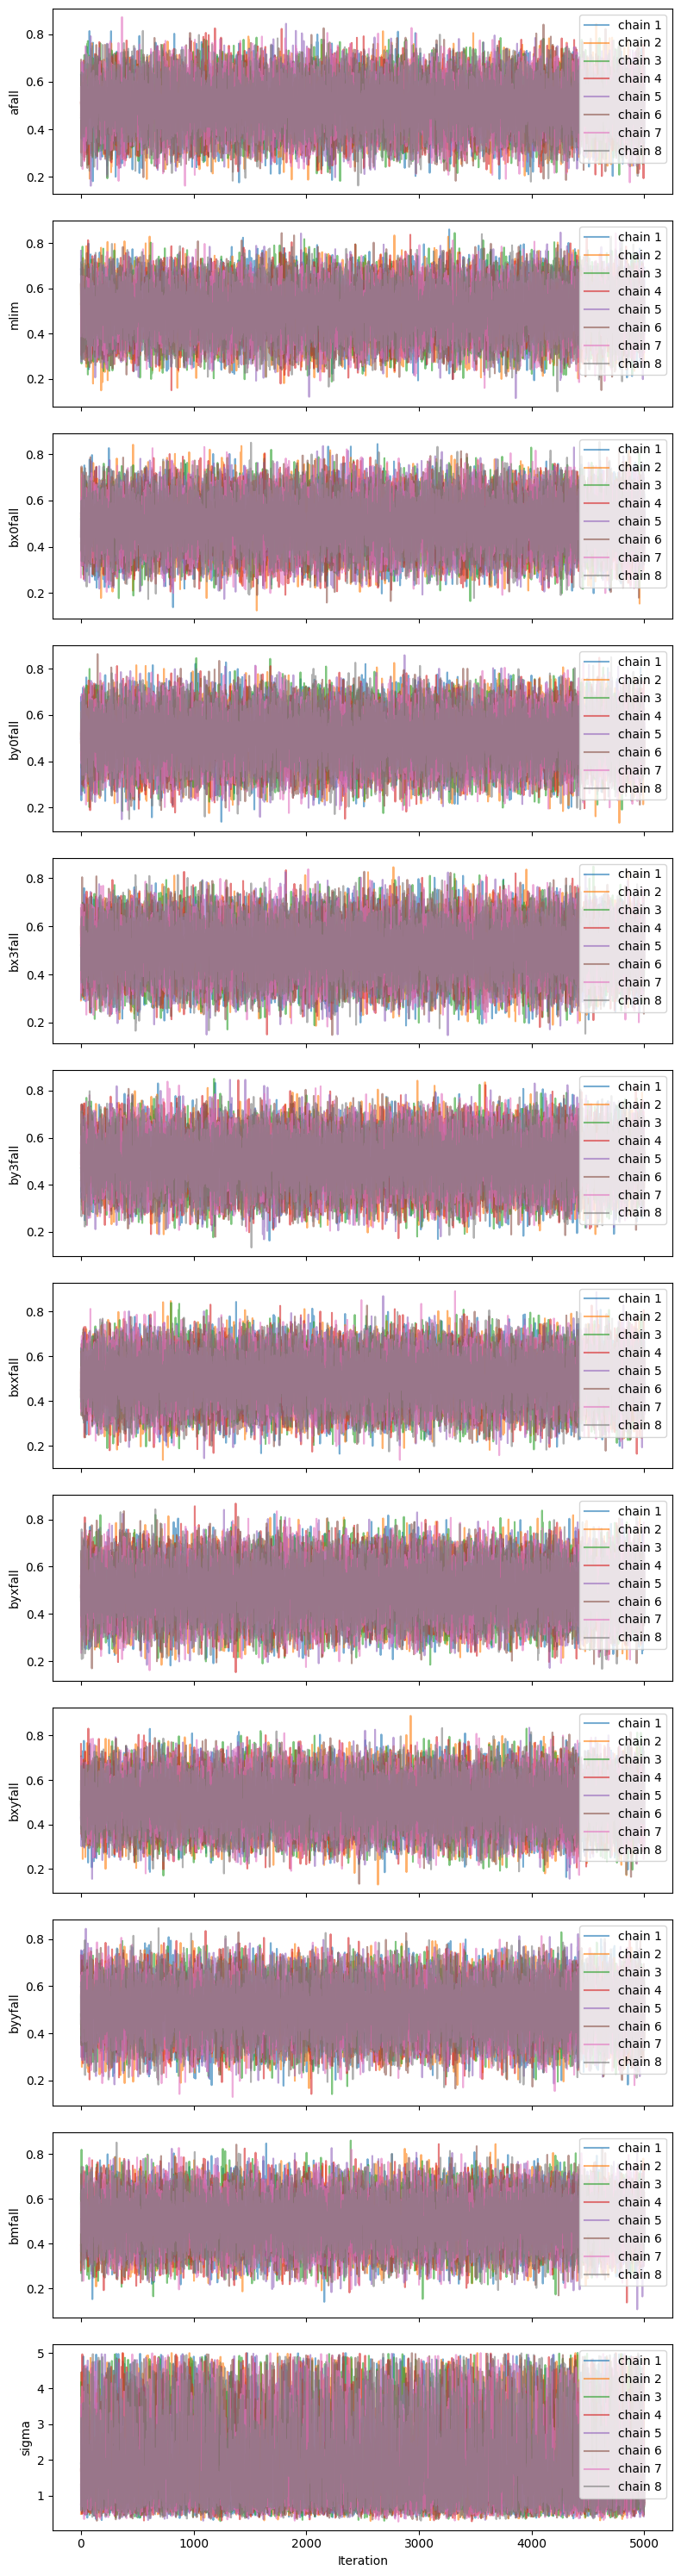

In [165]:
# def toy_lp(x): return tfd.Normal(0.,1.).log_prob(x)
# hmc = tfp.mcmc.HamiltonianMonteCarlo(toy_lp, step_size=0.1, num_leapfrog_steps=3)
# samples, _ = tfp.mcmc.sample_chain(num_results=500, current_state=0., kernel=hmc, num_burnin_steps=200, seed=0)
# plt.plot(samples.numpy())  # should look fuzzy, not flat
# tfd.Normal(0.,1.).log_prob(0)
# tfd.Uniform(low=0.0, high=1.0).log_prob(1.)
# i = 7

# --- 4. Trace plots ---
def plot_traces(posterior, pnames):
    its, chains, dims = posterior.shape
    fig, axes = plt.subplots(dims, 1, figsize=(8, 2.5*dims), sharex=True)
    for d in range(dims):
        for c in range(chains):
            axes[d].plot(posterior[:,c,d], alpha=0.6, label=f'chain {c+1}')
        axes[d].set_ylabel(pnames[d])
        axes[d].legend(loc='upper right')
    axes[-1].set_xlabel('Iteration')
    plt.tight_layout()
    plt.show()
    
try:
    print("acceptance rate:", sum(kr.is_accepted.numpy())/num_samples)
except AttributeError:
    print("acceptance rate:", sum(kr.inner_results.is_accepted.numpy())/num_samples)
          
transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
plot_traces(transformed_samples, param_names)
# kr

In [166]:
# i=7
print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())
# print(test_run_kernel[i], test_run_step_sizes[i], test_run_time[i])

[[5000.     5000.     5000.     5000.     5000.     5000.     5000.
  5000.     5000.     5000.     5000.     1708.0286]
 [5000.     5000.     5000.     5000.     5000.     5000.     5000.
  5000.     5000.     5000.     5000.     1493.1276]
 [5000.     5000.     5000.     5000.     5000.     5000.     5000.
  5000.     5000.     5000.     5000.     1733.8282]
 [5000.     5000.     5000.     5000.     5000.     5000.     5000.
  5000.     5000.     5000.     5000.     1539.3268]
 [5000.     5000.     5000.     5000.     5000.     5000.     5000.
  5000.     5000.     5000.     5000.     1460.5132]
 [5000.     5000.     5000.     5000.     5000.     5000.     5000.
  5000.     5000.     5000.     5000.     1471.9993]
 [5000.     5000.     5000.     5000.     5000.     5000.     5000.
  5000.     5000.     5000.     5000.     1840.9666]
 [5000.     5000.     5000.     5000.     5000.     5000.     5000.
  5000.     5000.     5000.     5000.     1698.9827]]
[1.0002822  0.9998248  0.999920

# postprocessing

In [167]:
transformed_samples

<tf.Tensor: shape=(5000, 8, 12), dtype=float32, numpy=
array([[[0.6291509 , 0.6853178 , 0.54438347, ..., 0.59829414,
         0.6347952 , 1.9040234 ],
        [0.51116335, 0.5317653 , 0.41553575, ..., 0.41893002,
         0.39298922, 0.48928744],
        [0.44798157, 0.61776745, 0.5185451 , ..., 0.5622293 ,
         0.6236321 , 2.769835  ],
        ...,
        [0.45796385, 0.6227812 , 0.44382834, ..., 0.4406622 ,
         0.3152048 , 1.7017376 ],
        [0.44375613, 0.38912776, 0.26640704, ..., 0.5627535 ,
         0.5835312 , 0.58355755],
        [0.57318217, 0.6623074 , 0.5224226 , ..., 0.48124233,
         0.5992276 , 1.3107778 ]],

       [[0.6291509 , 0.6853178 , 0.54438347, ..., 0.59829414,
         0.6347952 , 1.9040234 ],
        [0.51116335, 0.5317653 , 0.41553575, ..., 0.41893002,
         0.39298922, 0.48928744],
        [0.4391497 , 0.4079204 , 0.55078924, ..., 0.37883738,
         0.26815674, 4.1789765 ],
        ...,
        [0.6927959 , 0.5255797 , 0.51522475, ..., 0.5

In [168]:
Na_norm = IC_norm[0,0].astype('float32')
Na_col = tf.fill([tf.shape(transformed_samples[:,:,:-1])[0], 1], Na_norm)
Na_col3d = tf.tile(Na_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([Na_col3d, transformed_samples[:,:,:-1]], axis=2)
# w_norm = IC_norm[0,1].astype('float32')
# w_col = tf.fill([tf.shape(samples_bounded)[0], 1], w_norm)

In [169]:
samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = minmaxscale.inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

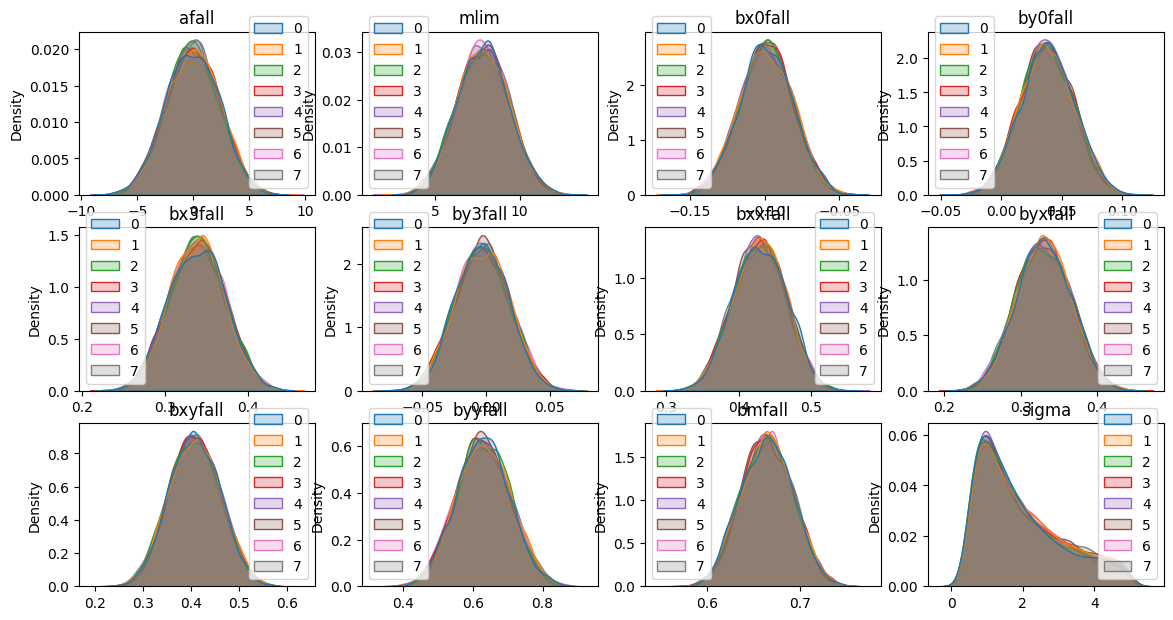

In [170]:
import matplotlib.gridspec as gridspec

samples_origval = np.concatenate((samples_raw_vals, transformed_samples[:,:,-1:]), axis=2)

fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
# for iparam, param_name in enumerate(param_names):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True)
    plt.title(param_name)
    # plt.plot((param_mean[iparam], param_mean[iparam]), ax.get_ylim(), color='tab:red')

plt.show()


##  save distribution for PPE

In [171]:
samples_raw_vals.shape

(5000, 8, 11)

In [172]:
nbins = 50
nparam = len(param_names)
count = {}
bins = {}
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

In [173]:
import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset('MCMC_posterior/' + case_name + '_r0_param_psd_narrow.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names)-1)
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names[:-1], dtype='S')
for i, pname in enumerate(param_names[:-1]):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

sigma_dens_var[:] = count['sigma'].astype('float32')
sigma_edge_var[:] = bins['sigma']
ncfile.close()

In [174]:
count['sigma'].astype('float32')

array([0.00235 , 0.01175 , 0.02865 , 0.038725, 0.04595 , 0.047925,
       0.049375, 0.045675, 0.044   , 0.04135 , 0.03825 , 0.0375  ,
       0.032825, 0.031275, 0.02985 , 0.0286  , 0.02535 , 0.0245  ,
       0.021825, 0.02285 , 0.02025 , 0.020925, 0.01785 , 0.01845 ,
       0.017025, 0.01695 , 0.0152  , 0.014725, 0.0133  , 0.0138  ,
       0.013   , 0.012525, 0.012175, 0.011925, 0.0098  , 0.010225,
       0.01025 , 0.0106  , 0.009175, 0.009275, 0.007975, 0.008025,
       0.008525, 0.007675, 0.007825, 0.007825, 0.0074  , 0.006575,
       0.006325, 0.00585 ], dtype=float32)

In [55]:
pd.DataFrame.from_dict(count).to_csv('MCMC_posterior/' + case_name + '_r0_param_density_narrow.csv', index=False)
pd.DataFrame.from_dict(bins).to_csv('MCMC_posterior/' + case_name + '_r0_param_bins_narrow.csv', index=False)

In [365]:
case_name

'rainshaftdt300'

## update params csv

In [ ]:
original_params = pd.read_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_RICO.csv')
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    updated_params.loc[0, param_name] = weighted_mean

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_AHMC.csv', index=False)

## validation

In [145]:
tsamples_combine_chains = transformed_samples.numpy().reshape(num_samples*nchains, nparam)
meanresult = np.mean(tsamples_combine_chains[:,:-1], axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)
vars_after_MCMC_norm = cc_model(meanresults_incl_ics)


In [146]:
y_predict = vars_after_MCMC_norm[1][valid_mask]
y_true = tgt_all[valid_mask]

In [147]:
vars_after_MCMC_norm[1].shape

TensorShape([11, 2884])

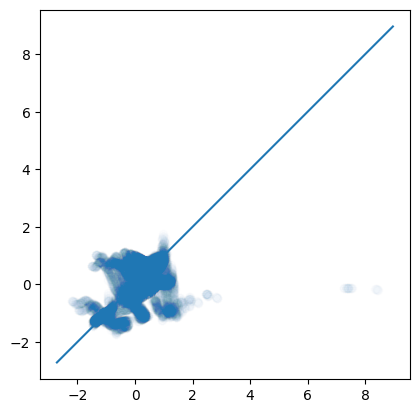

In [149]:
plt.scatter(y_true, y_predict, alpha=0.01)
ax = plt.gca()
ax.set_aspect('equal')
ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
plt.plot([ax_min, ax_max], [ax_min, ax_max])
# plt.xscale('log')
# plt.yscale('log')
